In [1]:
import os
import csv
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', None)

# importing necesary packages
import numpy as np
import pandas as pd
import pickle
import itertools
import timeit
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import shapely.wkt

# graphing libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib.pylab import rcParams

# modeling libraries
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima_model import ARMA
import statsmodels.api as sm

# ignore warnings
from warnings import filterwarnings
filterwarnings('ignore')

/Users/em/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Import Data

In [2]:
# Replace 'your_pickle_file.pkl' with the path to your pickle file
file_path = 'raw_dataframe.pkl'

# Open the file in read-binary ('rb') mode
with open(file_path, 'rb') as file:
    # Load the data from the file into a variable
    df = pickle.load(file)

# Ensure that the loaded data is a DataFrame
if isinstance(df, pd.DataFrame):
    # df is a pandas DataFrame
    print(df.head())
else:
    raise TypeError("Loaded data is not a pandas DataFrame.")

         ID Case Number                 Date                 Block  IUCR  \
0   5741943    HN549294  2007-08-25 09:22:18    074XX N ROGERS AVE  0560   
1   1930689    HH109118  2002-01-05 21:24:00        007XX E 103 ST  0820   
2  13203321    JG415333  2023-09-06 17:00:00      002XX N Wells st  1320   
3  13210088    JG423627  2023-08-31 12:00:00  023XX W JACKSON BLVD  1153   
4  13210004    JG422532  2023-07-24 21:45:00  073XX S JEFFERY BLVD  0281   

              Primary Type                          Description  \
0                  ASSAULT                               SIMPLE   
1                    THEFT                       $500 AND UNDER   
2          CRIMINAL DAMAGE                           TO VEHICLE   
3       DECEPTIVE PRACTICE  FINANCIAL IDENTITY THEFT OVER $ 300   
4  CRIMINAL SEXUAL ASSAULT                       NON-AGGRAVATED   

                     Location Description  Arrest  Domestic  Beat  District  \
0                                   OTHER   False     False  

## Data Cleaning

#### Initial Data Review

In [3]:
# Review the structure of the dataset
print("Initial Number of Rows:", df.shape)

Initial Number of Rows: (7930146, 30)


#### Review number of Nulls

In [4]:
# Handle missing values
missing_values = df.isnull().sum()
print("Missing Values Before Cleaning:\n", missing_values)

Missing Values Before Cleaning:
 ID                                 0
Case Number                        0
Date                               0
Block                              0
IUCR                               0
Primary Type                       0
Description                        0
Location Description           11999
Arrest                             0
Domestic                           0
Beat                               0
District                          47
Ward                          614853
Community Area                613477
FBI Code                           0
X Coordinate                   89407
Y Coordinate                   89407
Year                               0
Updated On                         0
Latitude                       89407
Longitude                      89407
Location                       89407
Historical Wards 2003-2015    112668
Zip Codes                      89407
Community Areas               109507
Census Tracts                 107437
Wards

#### Drop Columns based on High Number of Nulls
Community Area, Ward, and Historical Wards 2003-2015  had the highest number of null values. Dropping these will make it less challenging to perform meaningful analysis

In [5]:
# Drop columns with high null values ('Community Area','Ward', and Historical Wards 2003-2015' columns
df.drop(['Community Area', 'Ward', 'Historical Wards 2003-2015'], axis=1, inplace=True)

In [6]:
# Rerun the list for missing values
missing_values = df.isnull().sum()
print("Missing Values Before Cleaning:\n", missing_values)

Missing Values Before Cleaning:
 ID                             0
Case Number                    0
Date                           0
Block                          0
IUCR                           0
Primary Type                   0
Description                    0
Location Description       11999
Arrest                         0
Domestic                       0
Beat                           0
District                      47
FBI Code                       0
X Coordinate               89407
Y Coordinate               89407
Year                           0
Updated On                     0
Latitude                   89407
Longitude                  89407
Location                   89407
Zip Codes                  89407
Community Areas           109507
Census Tracts             107437
Wards                     109386
Boundaries - ZIP Codes    109454
Police Districts          108329
Police Beats              108303
dtype: int64


In [7]:
# Review duplicate entries
duplicate_mask = df.duplicated()
duplicates = df[duplicate_mask]
print("Number of Duplicate Rows:", len(duplicates))

Number of Duplicate Rows: 0


In [8]:
# Count the number of duplicate rows based on 'ID' and 'Case Number'
duplicate_count = df.duplicated(subset=['ID', 'Case Number']).sum()

# Print the number of duplicate rows
print(f"Number of duplicate rows based on 'ID' and 'Case Number': {duplicate_count}")

Number of duplicate rows based on 'ID' and 'Case Number': 0


In [9]:
# Handle data types (Convert'Date' column to datetime)
df['Date'] = pd.to_datetime(df['Date'])

In [10]:
# Create a dictionary to store rows lost by year
rows_lost_by_year = {}

# Get sorted unique years in ascending order
unique_years = sorted(df['Date'].dt.year.unique())

# Initialize a variable to track the total number of rows lost
total_rows_lost = 0

# Iterate through sorted unique years
for year in unique_years:
    # Create a subset for each year
    data_year = df[df['Date'].dt.year == year]
    
    # Count rows before and after dropping null values
    rows_before = len(data_year)
    data_year.dropna(inplace=True)
    rows_after = len(data_year)
    
    # Calculate the number of rows lost
    rows_lost = rows_before - rows_after
    
    # Add the rows lost to the total
    total_rows_lost += rows_lost
    
    # Store the result in the dictionary
    rows_lost_by_year[year] = rows_lost

    # Print the number of rows before and after dropping null values for each year
    print(f"Year {year}:")
    print(f"Rows before dropping null values: {rows_before}")
    print(f"Rows after dropping null values: {rows_after}")
    print(f"Total Rows Lost for Year {year}: {rows_lost}\n")

Year 2001:
Rows before dropping null values: 485894
Rows after dropping null values: 482803
Total Rows Lost for Year 2001: 3091

Year 2002:
Rows before dropping null values: 486808
Rows after dropping null values: 469799
Total Rows Lost for Year 2002: 17009

Year 2003:
Rows before dropping null values: 475987
Rows after dropping null values: 470340
Total Rows Lost for Year 2003: 5647

Year 2004:
Rows before dropping null values: 469427
Rows after dropping null values: 465641
Total Rows Lost for Year 2004: 3786

Year 2005:
Rows before dropping null values: 453774
Rows after dropping null values: 448350
Total Rows Lost for Year 2005: 5424

Year 2006:
Rows before dropping null values: 448179
Rows after dropping null values: 444036
Total Rows Lost for Year 2006: 4143

Year 2007:
Rows before dropping null values: 437091
Rows after dropping null values: 434353
Total Rows Lost for Year 2007: 2738

Year 2008:
Rows before dropping null values: 427185
Rows after dropping null values: 418389
Tota

In [11]:
# Drop Rows for Years 2001 and 2002
# For the year 2002, 17,009 rows were dropped, which is a significant loss making it challenging for analysis.
# Therefore, we are dropping both 2001 and 2002 from the dataset.
years_to_drop = [2001, 2002]
filtered_df = df[~df['Year'].isin(years_to_drop)]
# Print the unique years in the filtered_df in ascending order
unique_years_filtered = sorted(filtered_df['Year'].unique())
print("Unique Years in filtered_df (in ascending order):", unique_years_filtered)

Unique Years in filtered_df (in ascending order): [2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]


In [12]:
filtered_df.shape

(6957444, 27)

In [13]:
# Handle missing values
missing_values = filtered_df.isnull().sum()
print("Missing Values Before Cleaning:\n", missing_values)

Missing Values Before Cleaning:
 ID                            0
Case Number                   0
Date                          0
Block                         0
IUCR                          0
Primary Type                  0
Description                   0
Location Description      11989
Arrest                        0
Domestic                      0
Beat                          0
District                     47
FBI Code                      0
X Coordinate              71112
Y Coordinate              71112
Year                          0
Updated On                    0
Latitude                  71112
Longitude                 71112
Location                  71112
Zip Codes                 71112
Community Areas           89801
Census Tracts             87916
Wards                     89684
Boundaries - ZIP Codes    89753
Police Districts          88751
Police Beats              88727
dtype: int64


In [14]:
# Correcting the approach
initial_rows= initial_rows = filtered_df.shape[0]  # Rows before dropping nulls
print('Dataset Shape Before Dropping Null Values:', filtered_df.shape)
filtered_df.dropna(inplace=True)
final_rows = filtered_df.shape[0]    # Rows after dropping nulls
print('Dataset Shape After Dropping Null Values:', filtered_df.shape)

# Calculate the impact of data cleaning accurately
total_rows_lost = initial_rows - final_rows
percentage_rows_lost = (total_rows_lost / initial_rows) * 100

print("Number of Rows Before Dropping Nulls:", initial_rows)
print("Number of Rows After Dropping Nulls:", final_rows)
print("Total Rows Lost:", total_rows_lost)
print("Percentage of Total Rows Lost:", percentage_rows_lost, "%")

Dataset Shape Before Dropping Null Values: (6957444, 27)
Dataset Shape After Dropping Null Values: (6853765, 27)
Number of Rows Before Dropping Nulls: 6957444
Number of Rows After Dropping Nulls: 6853765
Total Rows Lost: 103679
Percentage of Total Rows Lost: 1.4901880633175058 %


In [15]:
# 3. Create a new DataFrame called cleaned_df with the clean data
cleaned_df = filtered_df.copy()

In [16]:
# New columns for easier analysis
cleaned_df['Year'] = cleaned_df['Date'].dt.year
cleaned_df['Month'] = cleaned_df['Date'].dt.month
cleaned_df['Day'] = cleaned_df['Date'].dt.day
cleaned_df['Hour'] = cleaned_df['Date'].dt.hour
cleaned_df['Weekday'] = cleaned_df['Date'].dt.weekday

In [17]:
df_transposed = cleaned_df.describe().T

In [18]:
cleaned_df["Community Areas"] = cleaned_df["Community Areas"].astype(int)

## Cleaned Dataframe

In [19]:
cleaned_df.shape

(6853765, 31)

In [20]:
cleaned_df.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location,Zip Codes,Community Areas,Census Tracts,Wards,Boundaries - ZIP Codes,Police Districts,Police Beats,Month,Day,Hour,Weekday
2,13203321,JG415333,2023-09-06 17:00:00,002XX N Wells st,1320,CRIMINAL DAMAGE,TO VEHICLE,PARKING LOT / GARAGE (NON RESIDENTIAL),False,False,122,1.0,14,1174694.0,1901831.0,2023,2023-11-04 15:40:18,41.886018,-87.633938,"(41.886018055, -87.633937881)",14309.0,38,92.0,36.0,46.0,22.0,79.0,9,6,17,2
3,13210088,JG423627,2023-08-31 12:00:00,023XX W JACKSON BLVD,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,STREET,False,False,1225,12.0,11,1160870.0,1898642.0,2023,2023-09-16 15:41:56,41.877565,-87.684791,"(41.877565108, -87.68479102)",21184.0,29,766.0,46.0,28.0,15.0,139.0,8,31,12,3
4,13210004,JG422532,2023-07-24 21:45:00,073XX S JEFFERY BLVD,0281,CRIMINAL SEXUAL ASSAULT,NON-AGGRAVATED,APARTMENT,False,False,333,3.0,02,1190812.0,1856743.0,2023,2023-09-16 15:41:56,41.761919,-87.576209,"(41.7619185, -87.576209245)",22538.0,39,419.0,37.0,24.0,18.0,89.0,7,24,21,0
5,13210062,JG423596,2023-08-27 07:00:00,034XX N LAWNDALE AVE,0820,THEFT,$500 AND UNDER,APARTMENT,False,False,1732,17.0,06,1151117.0,1922554.0,2023,2023-09-16 15:41:56,41.943379,-87.719974,"(41.943378528, -87.7199738)",21538.0,22,138.0,21.0,39.0,1.0,20.0,8,27,7,6
6,13210107,JG411849,2023-09-04 21:30:00,053XX S HOMAN AVE,1310,CRIMINAL DAMAGE,TO PROPERTY,RESIDENCE - GARAGE,False,False,822,8.0,14,1154617.0,1869046.0,2023,2023-09-16 15:41:56,41.796477,-87.708541,"(41.796477414, -87.708540915)",22248.0,61,776.0,8.0,56.0,13.0,129.0,9,4,21,0


In [21]:
cleaned_df.to_pickle('cleaned_df.pkl')

## Exploratory Data Analysis

In [22]:
# Basic Information
print(cleaned_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 6853765 entries, 2 to 7930145
Data columns (total 31 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   ID                      int64         
 1   Case Number             object        
 2   Date                    datetime64[ns]
 3   Block                   object        
 4   IUCR                    object        
 5   Primary Type            object        
 6   Description             object        
 7   Location Description    object        
 8   Arrest                  bool          
 9   Domestic                bool          
 10  Beat                    int64         
 11  District                float64       
 12  FBI Code                object        
 13  X Coordinate            float64       
 14  Y Coordinate            float64       
 15  Year                    int32         
 16  Updated On              object        
 17  Latitude                float64       
 18  Longitu

In [23]:
print("\nDataset Summary:\n")
# Set pandas options to display large numbers as strings
pd.set_option('display.float_format', lambda x: '%.3f' % x)
cleaned_df.describe()


Dataset Summary:



,ID,Date,Beat,District,X Coordinate,Y Coordinate,Year,Latitude,Longitude,Zip Codes,Community Areas,Census Tracts,Wards,Boundaries - ZIP Codes,Police Districts,Police Beats,Month,Day,Hour,Weekday
count,6853765.000,6853765,6853765.000,6853765.000,6853765.000,6853765.000,6853765.000,6853765.000,6853765.000,6853765.000,6853765.000,6853765.000,6853765.000,6853765.000,6853765.000,6853765.000,6853765.000,6853765.000,6853765.000,6853765.000
mean,7841210.561,2011-11-13 19:25:53.027999232,1177.551,11.257,1164722.734,1885635.880,2011.366,41.842,-87.671,19126.499,38.806,381.142,25.611,31.613,14.937,150.620,6.540,15.649,13.111,2.995
min,1957.000,2003-01-01 00:00:00,111.000,1.000,1092647.000,1813896.000,2003.000,41.645,-87.935,2733.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.000,0.000
25%,5033349.000,2006-09-24 23:02:36,621.000,6.000,1153033.000,1858868.000,2006.000,41.768,-87.713,21184.000,25.000,176.000,13.000,16.000,10.000,83.000,4.000,8.000,9.000,1.000
50%,7857171.000,2010-12-22 06:43:00,1033.000,10.000,1166226.000,1890638.000,2010.000,41.856,-87.665,21560.000,37.000,378.000,26.000,30.000,16.000,153.000,7.000,16.000,14.000,3.000
75%,10677939.000,2016-09-13 12:00:00,1724.000,17.000,1176417.000,1909030.000,2016.000,41.906,-87.628,22216.000,57.000,577.000,37.000,52.000,20.000,222.000,9.000,23.000,19.000,5.000
max,13267404.000,2023-10-31 00:00:00,2535.000,31.000,1205116.000,1951573.000,2023.000,42.023,-87.525,26912.000,77.000,801.000,50.000,61.000,25.000,277.000,12.000,31.000,23.000,6.000
std,3182944.183,NaN,701.598,6.941,16187.603,31391.779,5.930,0.086,0.059,5715.420,20.021,230.507,14.693,19.134,6.429,78.530,3.329,8.830,6.743,1.985


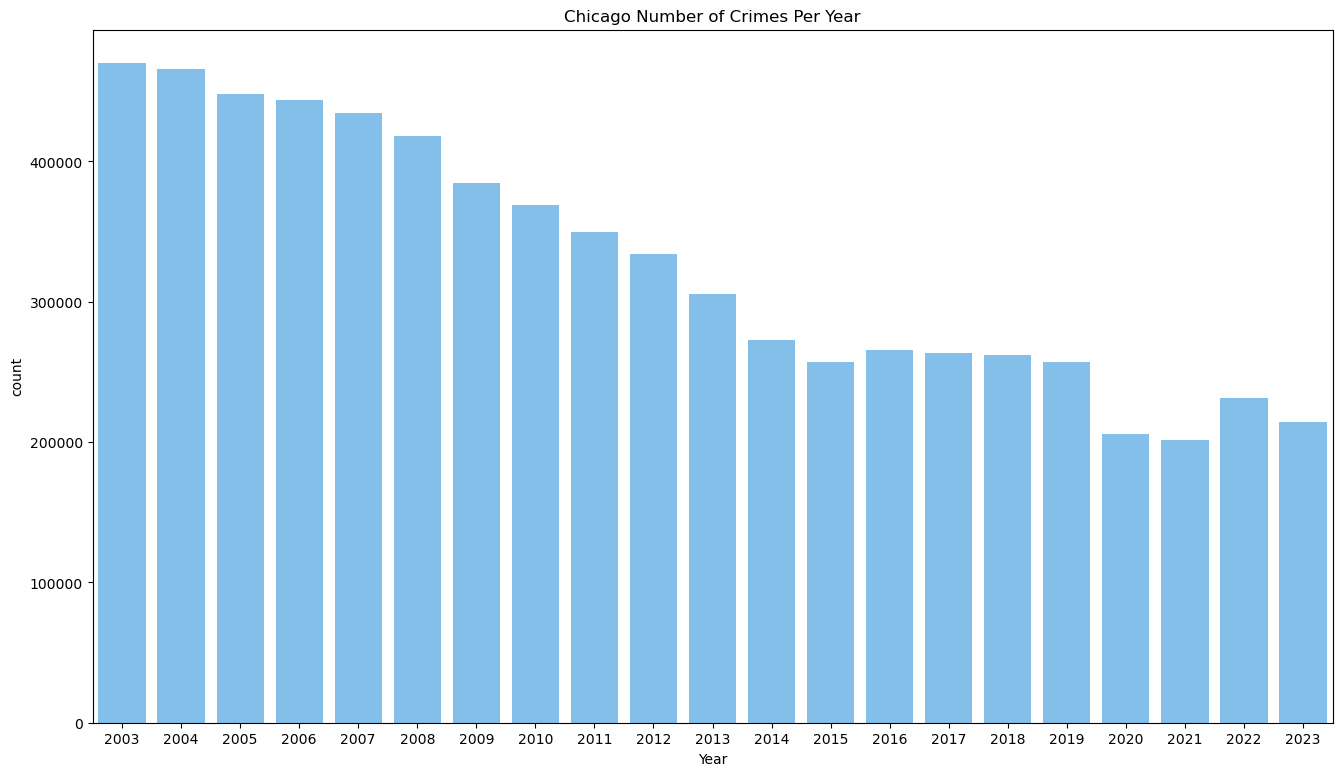

In [24]:
# Count of crimes per year
plt.figure(figsize=(16, 9))
sns.countplot(data=cleaned_df, x='Year', color = '#73C2FB')
plt.xticks()
plt.title('Chicago Number of Crimes Per Year')
plt.show()

In [25]:
# Convert 'Date' to datetime if it's not already
cleaned_df['Date'] = pd.to_datetime(cleaned_df['Date'])

# Extracting year and month
cleaned_df['Year'] = cleaned_df['Date'].dt.year
cleaned_df['Month'] = cleaned_df['Date'].dt.month

# Group data by year and month to count occurrences
monthly_crime_counts = cleaned_df.groupby(['Year', 'Month']).size().reset_index(name='Crime Count')

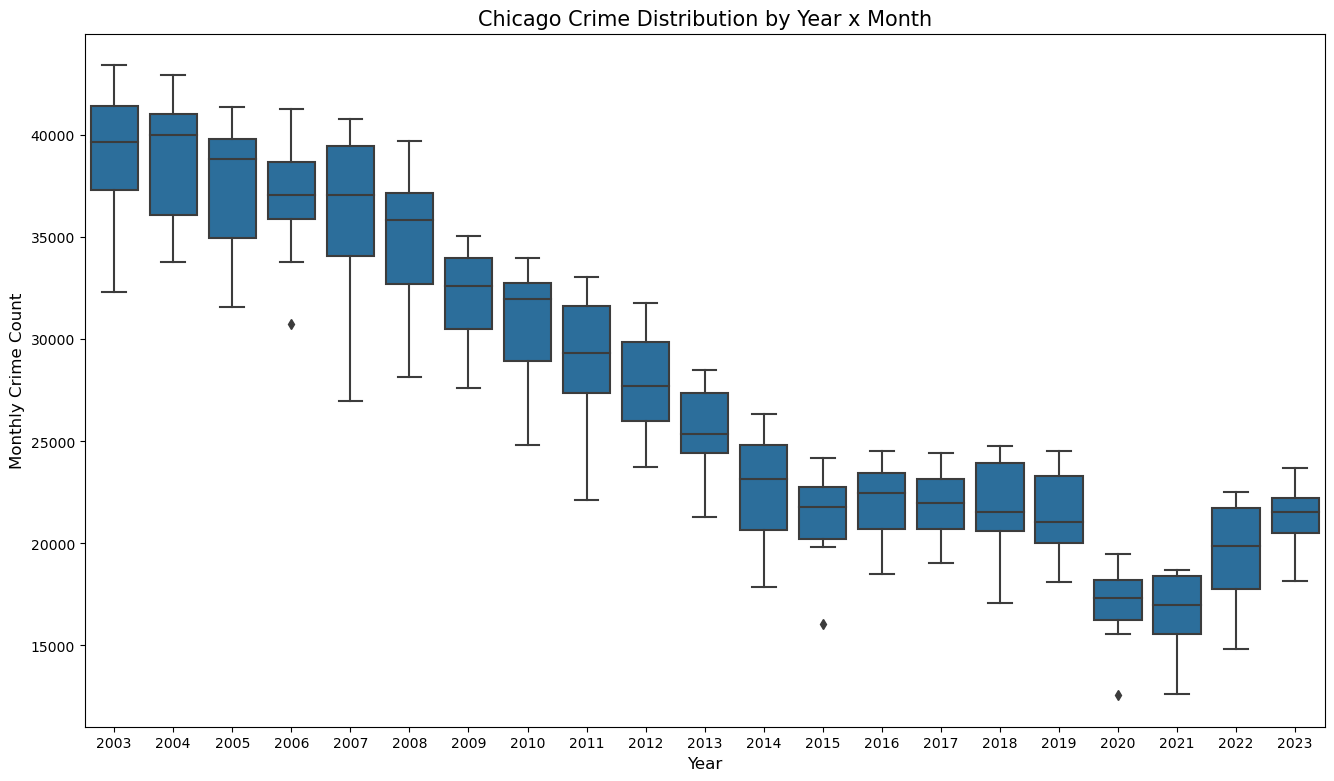

In [26]:
# Plotting the box plot with years on the x-axis
plt.figure(figsize=(16, 9))
sns.boxplot(x='Year', y='Crime Count', data=monthly_crime_counts, color = '#1971AE')

# Setting figure title and labels
plt.title('Chicago Crime Distribution by Year x Month', size=15)
plt.xlabel('Year', size=12)
plt.ylabel('Monthly Crime Count', size=12)
plt.xticks()  # Rotate x-axis labels for better readability

# Displaying the graph
plt.show()

In [27]:
from scipy import stats

# Assuming 'monthly_crime_counts' is your DataFrame with the aggregated crime data

# Calculate Z-scores for the 'Crime Count' column
monthly_crime_counts['Z_scores'] = stats.zscore(monthly_crime_counts['Crime Count'])

# Set a threshold for Z-scores to define outliers
threshold = 3

# Identify outliers
outliers = monthly_crime_counts[(monthly_crime_counts['Z_scores'] > threshold) | (monthly_crime_counts['Z_scores'] < -threshold)]

# Decide what to do with outliers
# For demonstration, let's just print them
print(outliers)


Empty DataFrame
Columns: [Year, Month, Crime Count, Z_scores]
Index: []


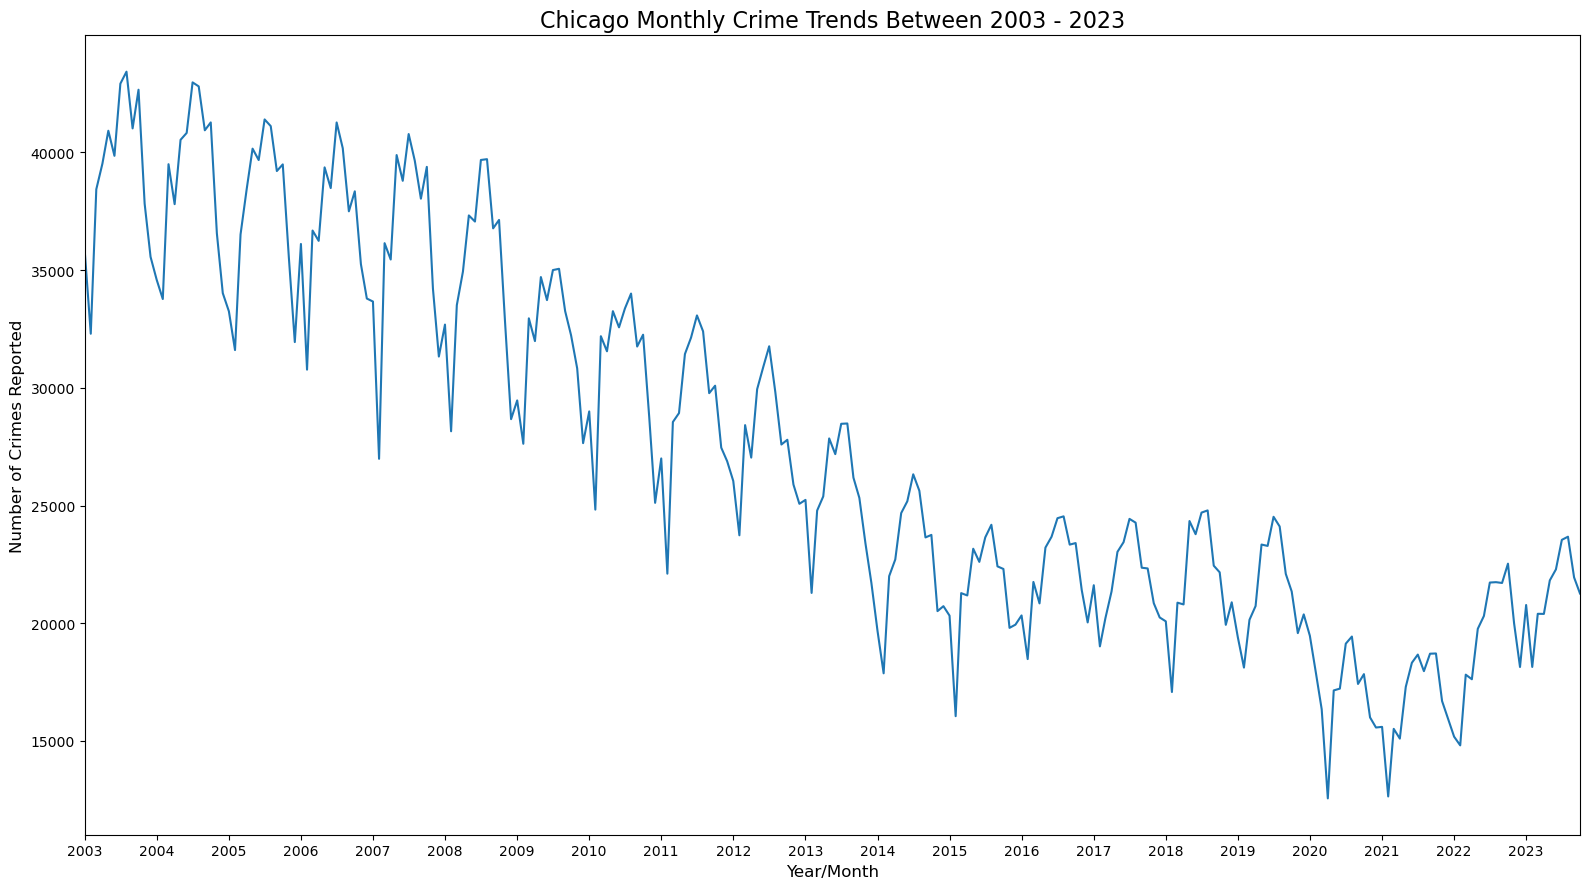

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# Assuming df is your dataframe and it has been loaded properly with 'Year' and 'Month' columns

# Group data by year and month to count occurrences
monthly_crime_counts = cleaned_df.groupby(['Year', 'Month']).size().reset_index(name='Crime Count')

# Filter out the data for years outside 2001-2023
monthly_crime_counts = monthly_crime_counts[(monthly_crime_counts['Year'] >= 2002) & (monthly_crime_counts['Year'] <= 2023)]

# Creating a continuous date (Year-Month) for plotting
monthly_crime_counts['Year-Month'] = pd.to_datetime(monthly_crime_counts[['Year', 'Month']].assign(DAY=1))

# Plotting the line graph with Year-Month on the x-axis
plt.figure(figsize=(16, 9))
sns.lineplot(x='Year-Month', y='Crime Count', data=monthly_crime_counts)

# Setting figure title and labels
plt.title('Chicago Monthly Crime Trends Between 2003 - 2023', size=16)
plt.xlabel('Year/Month', size=12)
plt.ylabel('Number of Crimes Reported', size=12)

# Setting x-axis to display each year clearly
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Set x-axis limits to the first and last dates of the desired range
plt.xlim(monthly_crime_counts['Year-Month'].min(), monthly_crime_counts['Year-Month'].max())

plt.xticks()  # Rotate x-axis labels for better readability

# Ensure a tight layout so everything fits without overlap
plt.tight_layout()

# Displaying the graph
plt.show()


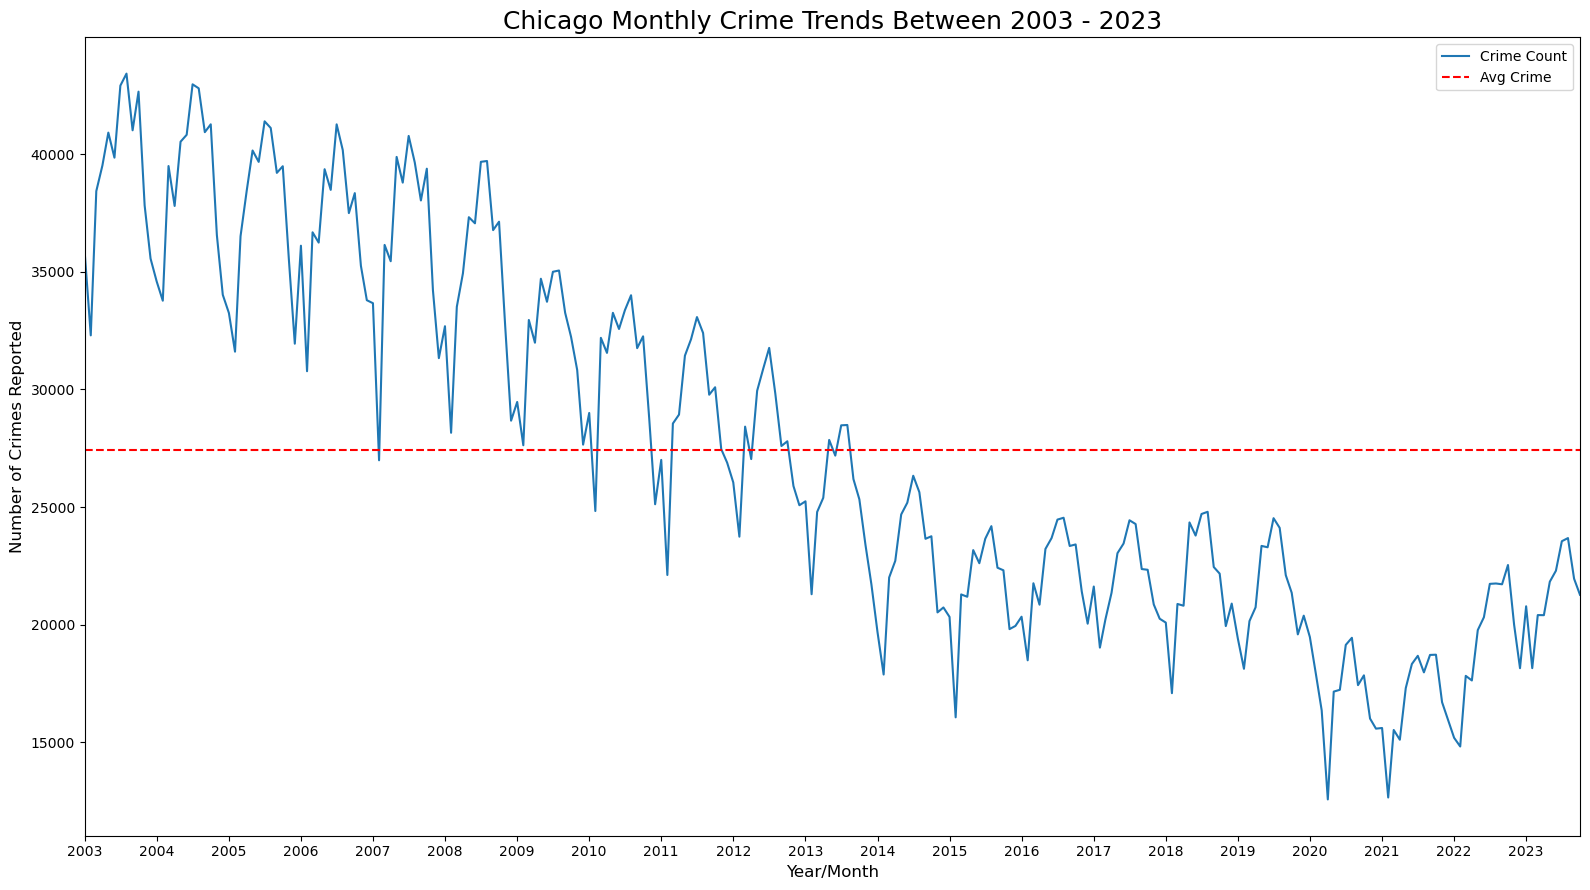

In [29]:
# Group data by year and month to count occurrences
monthly_crime_counts = cleaned_df.groupby(['Year', 'Month']).size().reset_index(name='Crime Count')

# Filter out the data for years 2000 and 2024
monthly_crime_counts = monthly_crime_counts[~monthly_crime_counts['Year'].isin([2000, 2024])]

# Creating a continuous date (Year-Month) for plotting
monthly_crime_counts['Year-Month'] = pd.to_datetime(monthly_crime_counts[['Year', 'Month']].assign(DAY=1))

# Calculate the average crime count
average_crime_count = monthly_crime_counts['Crime Count'].mean()

# Plotting the line graph with Year-Month on the x-axis
plt.figure(figsize=(16, 9))
sns.lineplot(x='Year-Month', y='Crime Count', data=monthly_crime_counts, label='Crime Count')

# Adding the average crime count line
plt.axhline(y=average_crime_count, color='r', linestyle='--', label='Avg Crime')

# Setting figure title and labels
plt.title('Chicago Monthly Crime Trends Between 2003 - 2023', size=18)
plt.xlabel('Year/Month', size=12)
plt.ylabel('Number of Crimes Reported', size=12)

# Setting x-axis to display each year clearly
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Explicitly setting x-axis limits to exclude 2002 and 2024
start_date = monthly_crime_counts['Year-Month'].min()
end_date = monthly_crime_counts['Year-Month'].max()
plt.xlim(start_date, end_date)

plt.xticks()  # Rotate x-axis labels for better readability

# Adding legend to the plot
plt.legend()

# Ensure a tight layout so everything fits without overlap
plt.tight_layout()

# Displaying the graph
plt.show()


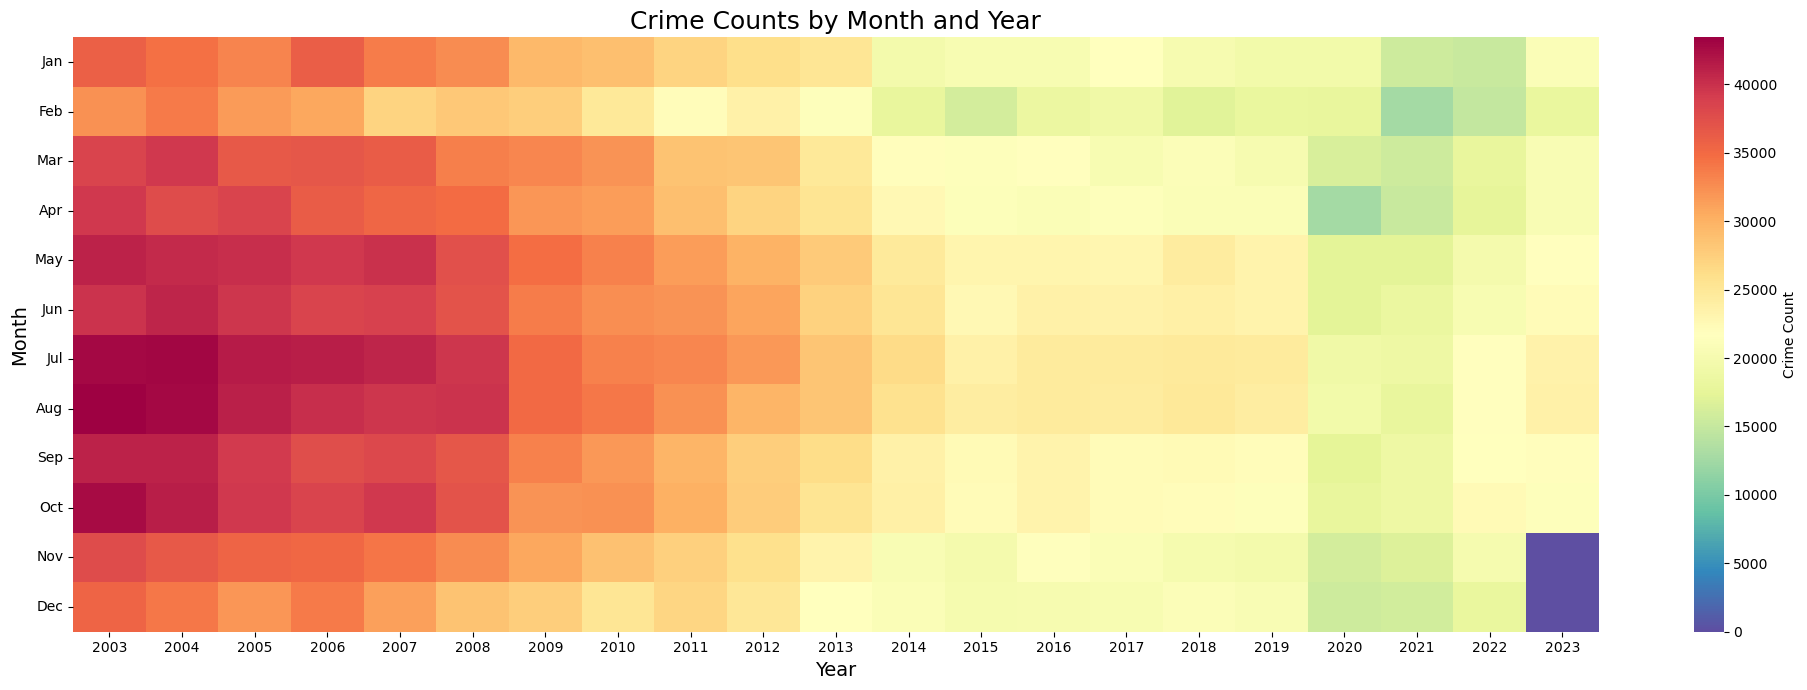

In [30]:
# Create a new 'Crime Count' column with a value of 1 for each row
cleaned_df['Crime Count'] = 1

# Create a pivot table to get crime counts by year and month
crime_counts_by_month = cleaned_df.pivot_table(index='Month', columns='Year', values='Crime Count', aggfunc='sum', fill_value=0)

# Set the 'Month' labels to spelled-out month names
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
crime_counts_by_month.index = month_names

# Create a heatmap with a red-to-yellow divergent color palette and border
plt.figure(figsize=(20, 7))
heatmap = sns.heatmap(crime_counts_by_month, cmap=plt.cm.Spectral_r, annot=False, cbar_kws={'label': 'Crime Count'})

# Flip the month and year labels to be horizontal
plt.xticks(rotation=0)  # Horizontal year labels
plt.yticks(rotation=0)  # Horizontal month labels

plt.title('Crime Counts by Month and Year', size=18)
plt.xlabel('Year', size=14)
plt.ylabel('Month', size=14)

plt.tight_layout()
plt.show()



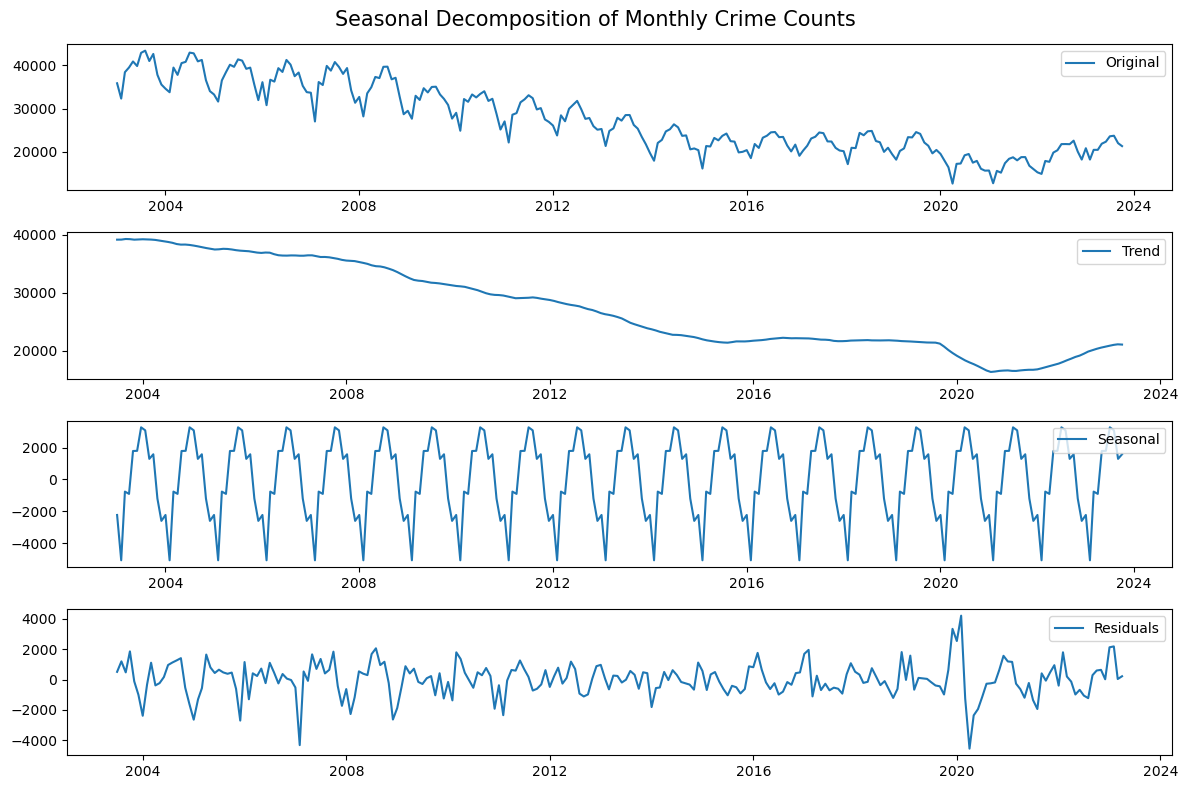

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose


# Combine 'Year' and 'Month' into a new column 'Date' with flexible parsing
cleaned_df['Date'] = pd.to_datetime(cleaned_df['Year'].astype(str) + '-' + cleaned_df['Month'].astype(str), errors='coerce')

# Remove rows with NaT (Not-a-Time) values, which may have resulted from parsing errors
cleaned_df.dropna(subset=['Date'], inplace=True)

# Grouping the data by 'Date' and summing up the crime counts
monthly_crime_counts = cleaned_df.groupby(['Date']).agg({'Crime Count': 'sum'}).reset_index()

# Perform seasonal decomposition
decomposition = seasonal_decompose(monthly_crime_counts['Crime Count'], model='additive', period=12)

# Add a new column for crime counts
monthly_crime_counts['Crime Count'] = decomposition.observed

# Plot the seasonal decomposition
plt.figure(figsize=(12, 8))
plt.suptitle('Seasonal Decomposition of Monthly Crime Counts', size=15)

# Original Data
plt.subplot(411)
plt.plot(monthly_crime_counts['Date'], monthly_crime_counts['Crime Count'], label='Original')
plt.legend(loc='upper right')

# Trend
plt.subplot(412)
plt.plot(monthly_crime_counts['Date'], decomposition.trend, label='Trend')
plt.legend(loc='upper right')

# Seasonal Component
plt.subplot(413)
plt.plot(monthly_crime_counts['Date'], decomposition.seasonal, label='Seasonal')
plt.legend(loc='upper right')

# Residuals
plt.subplot(414)
plt.plot(monthly_crime_counts['Date'], decomposition.resid, label='Residuals')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

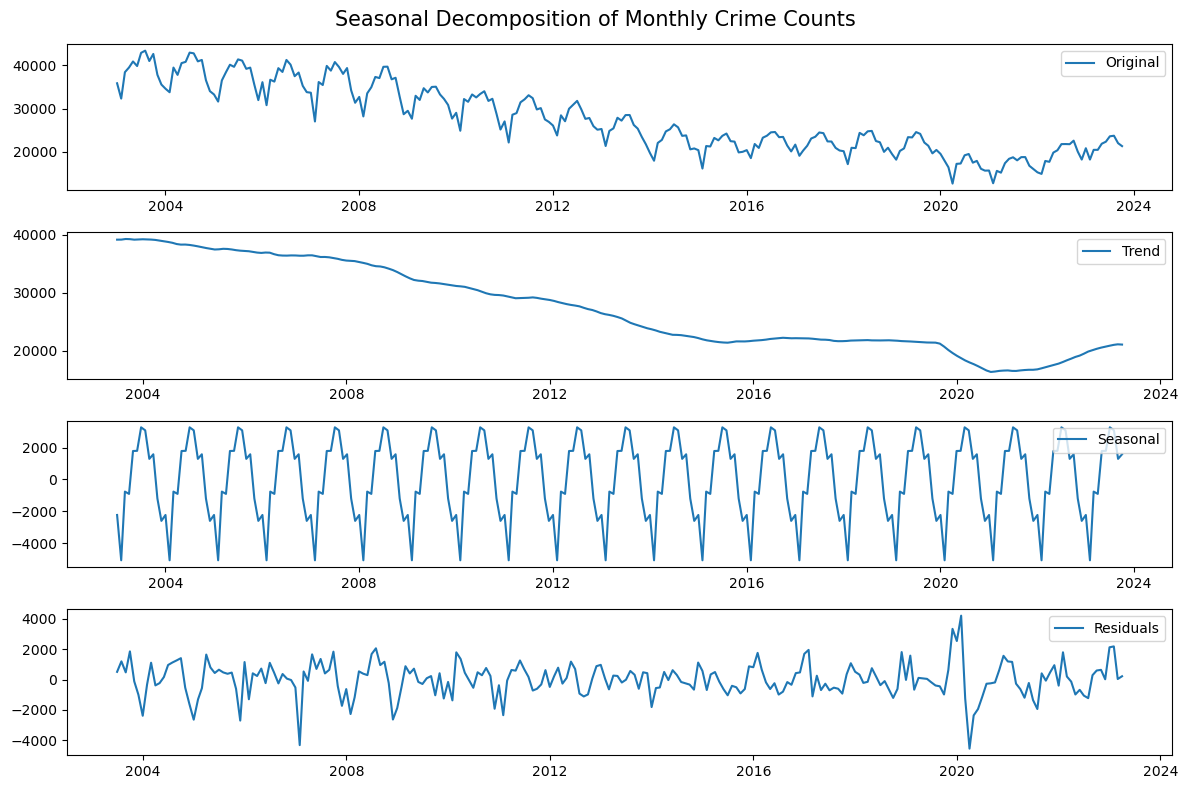

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Combine 'Year' and 'Month' into a new column 'Date' with flexible parsing
cleaned_df['Date'] = pd.to_datetime(cleaned_df['Year'].astype(str) + '-' + cleaned_df['Month'].astype(str), errors='coerce')

# Remove rows with NaT (Not-a-Time) values, which may have resulted from parsing errors
cleaned_df.dropna(subset=['Date'], inplace=True)

# Filter out the years 2000, 2001, 2002, and 2024
years_to_exclude = [2000, 2001, 2002, 2024]
monthly_crime_counts = cleaned_df[~cleaned_df['Year'].isin(years_to_exclude)]

# Grouping the data by 'Date' and summing up the crime counts
monthly_crime_counts = monthly_crime_counts.groupby(['Date']).agg({'Crime Count': 'sum'}).reset_index()

# Perform seasonal decomposition
decomposition = seasonal_decompose(monthly_crime_counts['Crime Count'], model='additive', period=12)

# Add a new column for crime counts
monthly_crime_counts['Crime Count'] = decomposition.observed

# Plot the seasonal decomposition
plt.figure(figsize=(12, 8))
plt.suptitle('Seasonal Decomposition of Monthly Crime Counts', size=15)

# Original Data
plt.subplot(411)
plt.plot(monthly_crime_counts['Date'], monthly_crime_counts['Crime Count'], label='Original')
plt.legend(loc='upper right')

# Trend
plt.subplot(412)
plt.plot(monthly_crime_counts['Date'], decomposition.trend, label='Trend')
plt.legend(loc='upper right')

# Seasonal Component
plt.subplot(413)
plt.plot(monthly_crime_counts['Date'], decomposition.seasonal, label='Seasonal')
plt.legend(loc='upper right')

# Residuals
plt.subplot(414)
plt.plot(monthly_crime_counts['Date'], decomposition.resid, label='Residuals')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

In [33]:
cleaned_df

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location,Zip Codes,Community Areas,Census Tracts,Wards,Boundaries - ZIP Codes,Police Districts,Police Beats,Month,Day,Hour,Weekday,Crime Count
2,13203321,JG415333,2023-09-01,002XX N Wells st,1320,CRIMINAL DAMAGE,TO VEHICLE,PARKING LOT / GARAGE (NON RESIDENTIAL),False,False,122,1.000,14,1174694.000,1901831.000,2023,2023-11-04 15:40:18,41.886,-87.634,"(41.886018055, -87.633937881)",14309.000,38,92.000,36.000,46.000,22.000,79.000,9,6,17,2,1
3,13210088,JG423627,2023-08-01,023XX W JACKSON BLVD,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,STREET,False,False,1225,12.000,11,1160870.000,1898642.000,2023,2023-09-16 15:41:56,41.878,-87.685,"(41.877565108, -87.68479102)",21184.000,29,766.000,46.000,28.000,15.000,139.000,8,31,12,3,1
4,13210004,JG422532,2023-07-01,073XX S JEFFERY BLVD,0281,CRIMINAL SEXUAL ASSAULT,NON-AGGRAVATED,APARTMENT,False,False,333,3.000,02,1190812.000,1856743.000,2023,2023-09-16 15:41:56,41.762,-87.576,"(41.7619185, -87.576209245)",22538.000,39,419.000,37.000,24.000,18.000,89.000,7,24,21,0,1
5,13210062,JG423596,2023-08-01,034XX N LAWNDALE AVE,0820,THEFT,$500 AND UNDER,APARTMENT,False,False,1732,17.000,06,1151117.000,1922554.000,2023,2023-09-16 15:41:56,41.943,-87.720,"(41.943378528, -87.7199738)",21538.000,22,138.000,21.000,39.000,1.000,20.000,8,27,7,6,1
6,13210107,JG411849,2023-09-01,053XX S HOMAN AVE,1310,CRIMINAL DAMAGE,TO PROPERTY,RESIDENCE - GARAGE,False,False,822,8.000,14,1154617.000,1869046.000,2023,2023-09-16 15:41:56,41.796,-87.709,"(41.796477414, -87.708540915)",22248.000,61,776.000,8.000,56.000,13.000,129.000,9,4,21,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7930141,13047495,JG229914,2023-04-01,003XX N JEFFERSON ST,1154,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT $300 AND UNDER,APARTMENT,False,False,1214,12.000,11,1172269.000,1902384.000,2023,2023-08-19 15:40:26,41.888,-87.643,"(41.887589411, -87.642826595)",4452.000,29,784.000,36.000,45.000,15.000,76.000,4,18,8,1,1
7930142,13168300,JG373901,2023-08-01,0000X W 95TH ST,031A,ROBBERY,ARMED - HANDGUN,SIDEWALK,False,False,634,6.000,03,1177527.000,1841973.000,2023,2023-08-19 15:40:26,41.722,-87.625,"(41.72169837, -87.625345212)",21861.000,45,187.000,13.000,59.000,20.000,242.000,8,7,18,0,1
7930143,13114024,JG309527,2023-06-01,031XX S AVERS AVE,0910,MOTOR VEHICLE THEFT,AUTOMOBILE,STREET,False,False,1031,10.000,07,1151205.000,1883542.000,2023,2023-08-19 15:40:26,41.836,-87.721,"(41.836323827, -87.720674149)",21569.000,32,200.000,28.000,57.000,21.000,167.000,6,20,19,1,1
7930144,13188860,JG398340,2023-08-01,078XX S SOUTH SHORE DR,1320,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,421,4.000,14,1198338.000,1853426.000,2023,2023-09-02 15:41:45,41.753,-87.549,"(41.752631346, -87.548737069)",22538.000,42,505.000,37.000,24.000,19.000,225.000,8,26,0,5,1


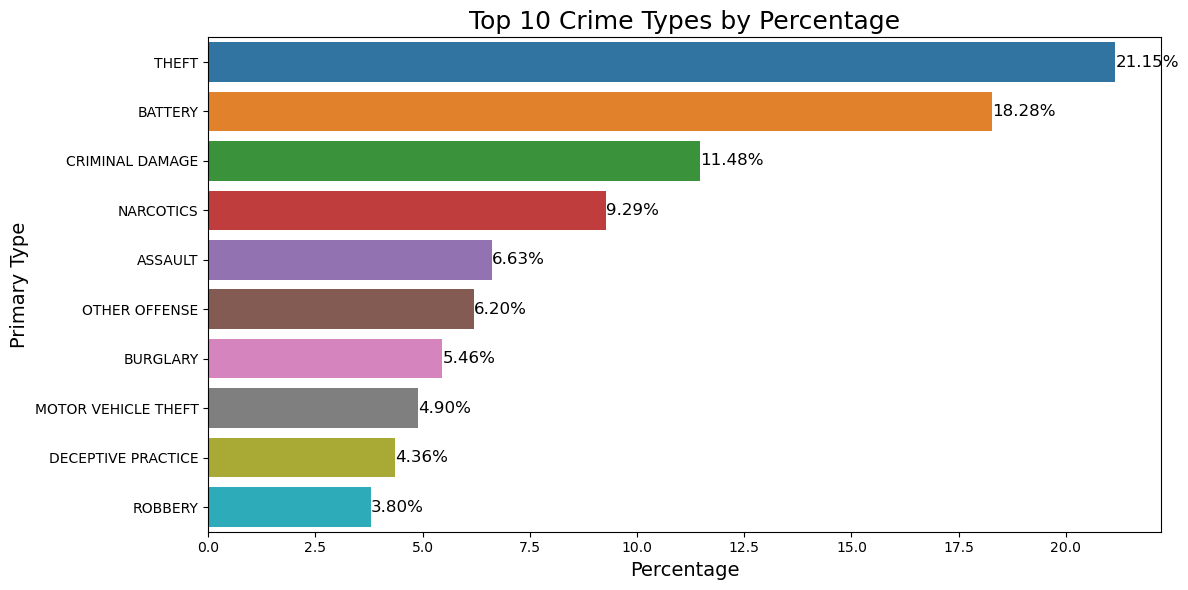

In [34]:
# Count the occurrences of each primary crime type
crime_type_counts = cleaned_df['Primary Type'].value_counts()

# Calculate the total number of crimes
total_crimes = crime_type_counts.sum()

# Get the top 10 primary crime types and calculate their percentage
top_10_crime_types = crime_type_counts.head(10) / total_crimes * 100

# Convert the series to a DataFrame for plotting
top_10_crime_types = top_10_crime_types.reset_index()
top_10_crime_types.columns = ['Primary Type', 'Percentage']

# Plot the horizontal bar chart for the top 10 primary crime types
plt.figure(figsize=(12, 6))
sns.barplot(x='Percentage', y='Primary Type', data=top_10_crime_types)

# Set figure title and labels
plt.title('Top 10 Crime Types by Percentage', size=18)
plt.xlabel('Percentage', size=14)
plt.ylabel('Primary Type', size=14)

# Display the percentage values on the bars
for index, value in enumerate(top_10_crime_types['Percentage']):
    plt.text(value, index, f'{value:.2f}%', va='center', fontsize=12)

plt.tight_layout()  # Ensure a tight layout so everything fits without overlap

# Display the graph
plt.show()